In [1]:
# -----------------------------
# 1. Import Libraries
# -----------------------------
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt


In [3]:
# -----------------------------
# 2. Load the Customer Shopping Dataset
# -----------------------------
df = pd.read_csv("customer_shopping_data.csv")
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
print(df.head())

Columns: ['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity', 'price', 'payment_method', 'invoice_date', 'shopping_mall']
Shape: (99457, 10)
  invoice_no customer_id  gender  age  category  quantity    price  \
0    I138884     C241288  Female   28  Clothing         5  1500.40   
1    I317333     C111565    Male   21     Shoes         3  1800.51   
2    I127801     C266599    Male   20  Clothing         1   300.08   
3    I173702     C988172  Female   66     Shoes         5  3000.85   
4    I337046     C189076  Female   53     Books         4    60.60   

  payment_method invoice_date   shopping_mall  
0    Credit Card     5/8/2022          Kanyon  
1     Debit Card   12/12/2021  Forum Istanbul  
2           Cash    9/11/2021       Metrocity  
3    Credit Card   16/05/2021    Metropol AVM  
4           Cash   24/10/2021          Kanyon  


In [4]:
# -----------------------------
# 3. Standardize Column Names
# -----------------------------
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# -----------------------------
# 4. Connect to SQLite and Save Data
# -----------------------------
import sqlite3
conn = sqlite3.connect("shopping_data.db")
df.to_sql("sales", conn, if_exists="replace", index=False)

99457

In [5]:
# -----------------------------
# 5. Query: Average Basket Size by Customer
# -----------------------------
basket_query = """
SELECT 
  customer_id,
  COUNT(DISTINCT invoice_no) AS num_orders,
  ROUND(SUM(quantity * price), 2) AS total_spent,
  ROUND(AVG(quantity * price), 2) AS avg_spent_per_order
FROM sales
GROUP BY customer_id
ORDER BY total_spent DESC
LIMIT 10;
"""
basket_df = pd.read_sql(basket_query, conn)
print("Top Customers by Total Spend:\n", basket_df)

Top Customers by Total Spend:
   customer_id  num_orders  total_spent  avg_spent_per_order
0     C998781           1      26250.0              26250.0
1     C991315           1      26250.0              26250.0
2     C988230           1      26250.0              26250.0
3     C987359           1      26250.0              26250.0
4     C986474           1      26250.0              26250.0
5     C984334           1      26250.0              26250.0
6     C983606           1      26250.0              26250.0
7     C979552           1      26250.0              26250.0
8     C977343           1      26250.0              26250.0
9     C975444           1      26250.0              26250.0


In [6]:
# -----------------------------
# 6. Query: Revenue by Category
# -----------------------------
category_query = """
SELECT 
  category,
  ROUND(SUM(quantity * price), 2) AS category_revenue,
  COUNT(*) AS total_items_sold
FROM sales
GROUP BY category
ORDER BY category_revenue DESC
LIMIT 10;
"""
category_df = pd.read_sql(category_query, conn)
print("Top Product Categories:\n", category_df)


Top Product Categories:
           category  category_revenue  total_items_sold
0         Clothing      1.139968e+08             34487
1            Shoes      6.655345e+07             10034
2       Technology      5.786235e+07              4996
3        Cosmetics      6.792863e+06             15097
4             Toys      3.980426e+06             10087
5  Food & Beverage      8.495351e+05             14776
6            Books      8.345529e+05              4981
7         Souvenir      6.358247e+05              4999


In [7]:
# -----------------------------
# 7. Cohort Analysis: Repeat Customers
# -----------------------------
cohort_query = """
WITH first_orders AS (
  SELECT customer_id, MIN(invoice_date) AS first_order_date
  FROM sales
  GROUP BY customer_id
),
repeat_customers AS (
  SELECT s.customer_id
  FROM sales s
  JOIN first_orders f ON s.customer_id = f.customer_id
  WHERE date(s.invoice_date) > date(f.first_order_date)
)
SELECT
  COUNT(DISTINCT s.customer_id) AS total_customers,
  COUNT(DISTINCT r.customer_id) AS repeat_customers,
  ROUND(100.0 * COUNT(DISTINCT r.customer_id) / COUNT(DISTINCT s.customer_id), 2) AS repeat_rate
FROM sales s
LEFT JOIN repeat_customers r ON s.customer_id = r.customer_id;
"""
cohort_df = pd.read_sql(cohort_query, conn)
print("Cohort Analysis (Repeat Rate):\n", cohort_df)


Cohort Analysis (Repeat Rate):
    total_customers  repeat_customers  repeat_rate
0            99457                 0          0.0


C:\Users\DELL\AppData\Local\Temp\ipykernel_22148\522677984.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


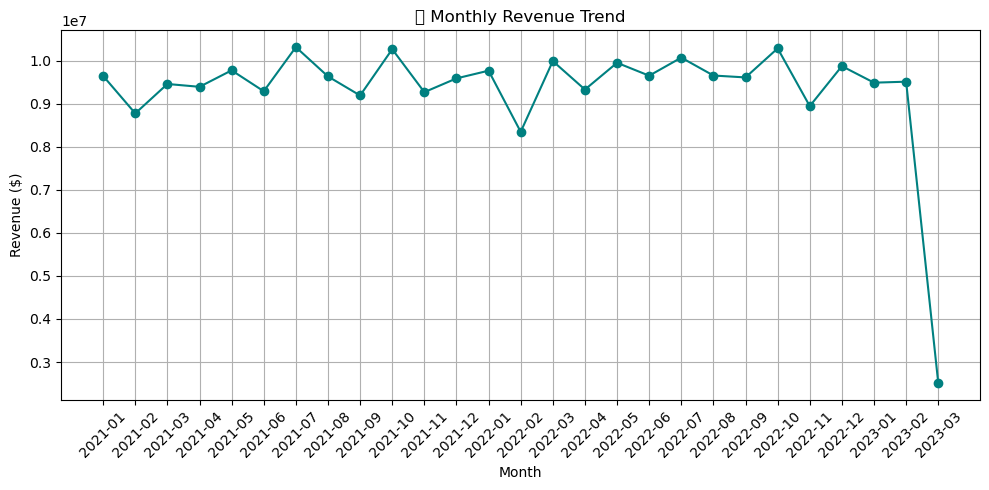

In [9]:
# -----------------------------
# 8. Plot: Monthly Revenue Trend
# -----------------------------
import matplotlib.pyplot as plt

# Convert invoice_date to datetime with correct format (DD/MM/YYYY)
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True)


# Extract month-year
df['month'] = df['invoice_date'].dt.to_period('M').astype(str)

# Re-upload updated dataframe with month column
df.to_sql("sales", conn, if_exists="replace", index=False)

revenue_query = """
SELECT 
  month,
  ROUND(SUM(quantity * price), 2) AS monthly_revenue
FROM sales
GROUP BY month
ORDER BY month;
"""
revenue_df = pd.read_sql(revenue_query, conn)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(revenue_df['month'], revenue_df['monthly_revenue'], marker='o', color='teal')
plt.title("📈 Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_22148\2630907439.py:18: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


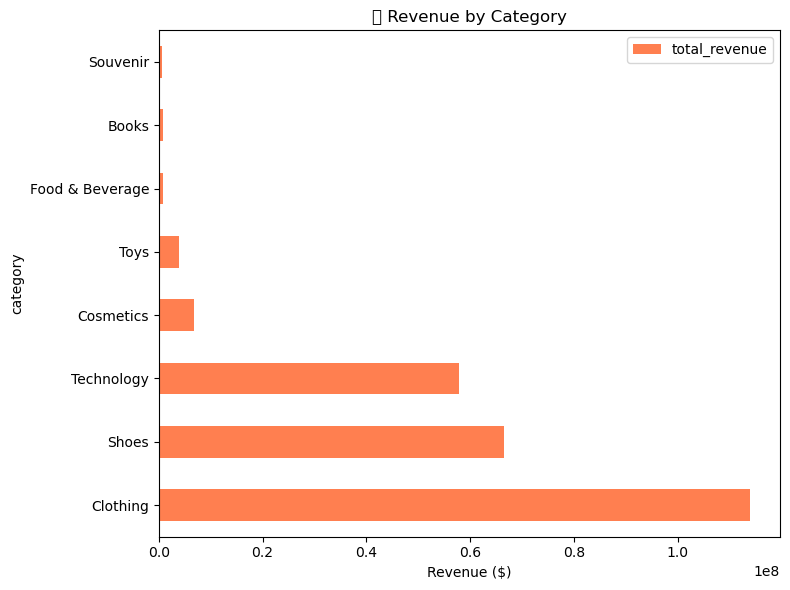

In [10]:
# SQL query to calculate total revenue for each product category
query = """
SELECT 
  category, 
  ROUND(SUM(quantity * price), 2) AS total_revenue
FROM sales
GROUP BY category
ORDER BY total_revenue DESC;
"""

# Execute query and load into DataFrame
df_category = pd.read_sql(query, conn)

# Horizontal bar plot for revenue by category
df_category.plot(kind='barh', x='category', y='total_revenue', color='coral', figsize=(8, 6))
plt.title("💰 Revenue by Category")
plt.xlabel("Revenue ($)")
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_22148\424811631.py:16: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


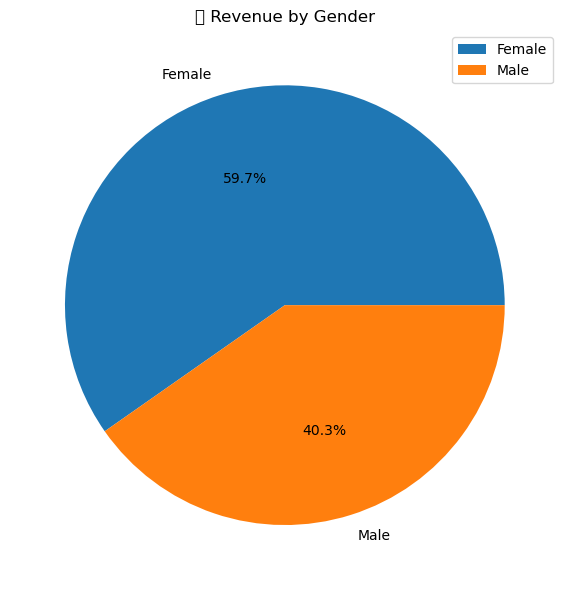

In [11]:
# SQL to get total revenue split by gender
query = """
SELECT 
  gender, 
  ROUND(SUM(quantity * price), 2) AS revenue
FROM sales
GROUP BY gender;
"""

df_gender = pd.read_sql(query, conn)

# Pie chart for gender-based revenue contribution
df_gender.plot(kind='pie', y='revenue', labels=df_gender['gender'], autopct='%1.1f%%', figsize=(6,6))
plt.title("🧍 Revenue by Gender")
plt.ylabel("")  # Hides y-axis label
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_22148\588014190.py:19: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127980 (\N{DEPARTMENT STORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


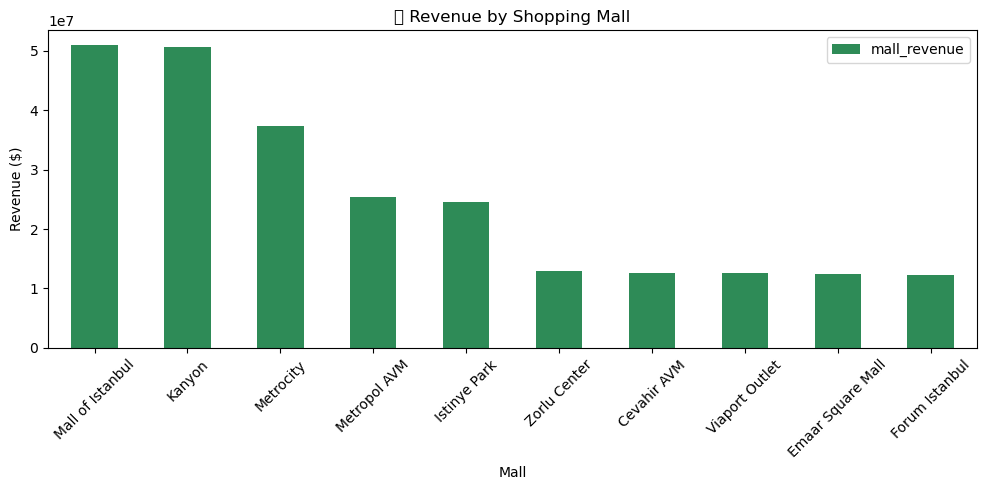

In [12]:
# SQL to get revenue generated by each shopping mall
query = """
SELECT 
  shopping_mall,
  ROUND(SUM(quantity * price), 2) AS mall_revenue
FROM sales
GROUP BY shopping_mall
ORDER BY mall_revenue DESC;
"""

df_mall = pd.read_sql(query, conn)

# Bar chart to visualize which malls earn more
df_mall.plot(kind='bar', x='shopping_mall', y='mall_revenue', color='seagreen', figsize=(10, 5))
plt.title("🏬 Revenue by Shopping Mall")
plt.xlabel("Mall")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# SQL to calculate average revenue per invoice (transaction)
query = """
SELECT 
  ROUND(SUM(quantity * price) / COUNT(DISTINCT invoice_no), 2) AS avg_basket_value
FROM sales;
"""

df_basket = pd.read_sql(query, conn)
print("🧺 Average Basket Value: $", df_basket.iloc[0, 0])


🧺 Average Basket Value: $ 2528.79


C:\Users\DELL\AppData\Local\Temp\ipykernel_22148\2962225771.py:20: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


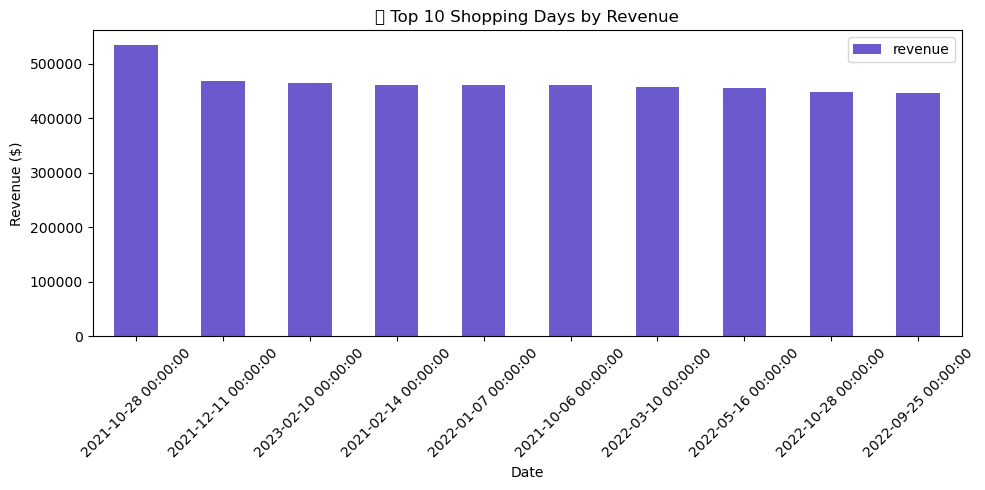

In [14]:
# SQL to find the top 10 days with highest revenue
query = """
SELECT 
  invoice_date,
  ROUND(SUM(quantity * price), 2) AS revenue
FROM sales
GROUP BY invoice_date
ORDER BY revenue DESC
LIMIT 10;
"""

df_top_days = pd.read_sql(query, conn)

# Plot revenue spikes on top shopping dates
df_top_days.plot(kind='bar', x='invoice_date', y='revenue', color='slateblue', figsize=(10, 5))
plt.title("📅 Top 10 Shopping Days by Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
